This notebook is based in the oficial TensorFlow NLP guide.
Please check the original for beter understanding.

https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S


# 1. Tokenization basic

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
sentences = [
    'I love my dog',
    'I love my cat'
]

Create a simple sentencess to demonstrate the tokenizer process

In [3]:
tokenizer = Tokenizer(num_words = 100)

In [4]:
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5}


In [5]:
# tokenizer also apply basic preprocessing on the text
sentences_new = [
    'I love my dog!',
    'I love my cat?'
]

In [6]:
tokenizer.fit_on_texts(sentences_new)
word_index = tokenizer.word_index
print(sentences_new)
print(word_index)

['I love my dog!', 'I love my cat?']
{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5}


As we can see new tokens was not created for "**dog!**" and "**cat?**".

# 2. Sentencess to data 

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

In [9]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [10]:
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
print(word_index)
print(sequences)

{'my': 1, 'love': 2, 'dog': 3, 'i': 4, 'you': 5, 'cat': 6, 'do': 7, 'think': 8, 'is': 9, 'amazing': 10}
[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]


We can see how each word is represented by a token. And how sentencess are formated as set of tokens.

Lets see wat happend if we give tokenizer a senteces with words thet were not previosly shown to it.

In [12]:
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

In [13]:
test_seq = tokenizer.texts_to_sequences(test_data)
print(word_index)
print(test_seq)

{'my': 1, 'love': 2, 'dog': 3, 'i': 4, 'you': 5, 'cat': 6, 'do': 7, 'think': 8, 'is': 9, 'amazing': 10}
[[4, 2, 1, 3], [1, 3, 1]]


The sentence "**i really love my dog**" contains 5 words. But the tokenize sequence contains only 4 tokens. The word "**really**" was not previosly tokenized, so now it's just being ignored. But in this way we loose the information that *at least* some word were there. That also leads to shortening the sequances.

To fix this we can use **OOV-token** parameter.

In [14]:
tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)

In [15]:
test_seq = tokenizer.texts_to_sequences(test_data)
print(word_index)
print(test_seq)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]


We still loose the information, but at least now we know where was unknown words and how much of them. And our sequencess are the same lengs.

But not all sentences contain equal amount of words. What to do in this case?

The advanced answer is Ragged tensors. But it's another topic.
Simplier solution is **padding**

In [16]:
padded = pad_sequences(sequences)

In [17]:
print(word_index)
print(sequences)
print(padded)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]
[[ 0  0  0  5  3  2  4]
 [ 0  0  0  5  3  2  7]
 [ 0  0  0  6  3  2  4]
 [ 8  6  9  2  4 10 11]]


We can see the 0's at the begining, which creating this "pad" and make each sequence the same length. By default padding matching the length of the longest sentence.

We can change 0's to be desplayed at the end of each sequence by setting **padding** parameter to *post*

Also, if we dont want the sequence to be equal the length of longest sentence we can limit it by **maxlen** parameter.

If we limiting the length we can deside how to chop our sequence, from the end or from the begining by specifying **truncation** parameter.

In [18]:
padded = pad_sequences(sequences, padding = "post")
print(padded)

[[ 5  3  2  4  0  0  0]
 [ 5  3  2  7  0  0  0]
 [ 6  3  2  4  0  0  0]
 [ 8  6  9  2  4 10 11]]


In [19]:
padded = pad_sequences(sequences, padding = 'post',
                      maxlen = 5, truncating = 'post')
print(padded)

[[5 3 2 4 0]
 [5 3 2 7 0]
 [6 3 2 4 0]
 [8 6 9 2 4]]


# 3. Sentiment clasification model

In [20]:
import json

In [21]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2024-10-15 22:28:11--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.67.27, 142.250.204.27, 142.250.66.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.67.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: '/tmp/sarcasm.json'

/tmp/sarcasm.json   100%[===================>]   5.38M  4.45MB/s    in 1.2s    

2024-10-15 22:28:13 (4.45 MB/s) - '/tmp/sarcasm.json' saved [5643545/5643545]



In [22]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [23]:
tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [24]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = 'post')
word_index = tokenizer.word_index
print(list(word_index.items())[:10])
print(padded[0])
print(padded.shape)

[('<OOV>', 1), ('to', 2), ('of', 3), ('the', 4), ('in', 5), ('for', 6), ('a', 7), ('on', 8), ('and', 9), ('with', 10)]
[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(26709, 40)


We can se the first few tokens of this dataset, as well as how the sentence is formated after tokenization and padding.

But how do we split our data on training and test sets?

In [25]:
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

But in order to truly test our tokenizer we need to give it the data that it has not seen before, so lets rewrite some of the code.

In [26]:
embedding_dim = 16
training_size = 20000

In [27]:
tokenizer = Tokenizer(num_words = 10000, oov_token = "<OOV>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = 100, padding = 'post', truncating = 'post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = 100, padding = 'post', truncating = 'post')

Now wen we processed our data we need to build and train the model in order to clasify text on sarcastic/ not sarcastic.

In [28]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - 6ms/step - accuracy: 0.5721 - loss: 0.6761 - val_accuracy: 0.7560 - val_loss: 0.6451
Epoch 2/30
625/625 - 2s - 3ms/step - accuracy: 0.7602 - loss: 0.5184 - val_accuracy: 0.8186 - val_loss: 0.4377
Epoch 3/30
625/625 - 2s - 3ms/step - accuracy: 0.8279 - loss: 0.3945 - val_accuracy: 0.7386 - val_loss: 0.5180
Epoch 4/30
625/625 - 2s - 4ms/step - accuracy: 0.8512 - loss: 0.3454 - val_accuracy: 0.7851 - val_loss: 0.4423
Epoch 5/30
625/625 - 3s - 4ms/step - accuracy: 0.8692 - loss: 0.3100 - val_accuracy: 0.8393 - val_loss: 0.3676
Epoch 6/30
625/625 - 2s - 3ms/step - accuracy: 0.8845 - loss: 0.2790 - val_accuracy: 0.8536 - val_loss: 0.3482
Epoch 7/30
625/625 - 2s - 3ms/step - accuracy: 0.8984 - loss: 0.2512 - val_accuracy: 0.8547 - val_loss: 0.3453
Epoch 8/30
625/625 - 2s - 3ms/step - accuracy: 0.9035 - loss: 0.2389 - val_accuracy: 0.8322 - val_loss: 0.3865
Epoch 9/30
625/625 - 2s - 3ms/step - accuracy: 0.9071 - loss: 0.2285 - val_accuracy: 0.8529 - val_loss: 0.3511
E

We got 83% accuracy on the test data. Which is prety good.

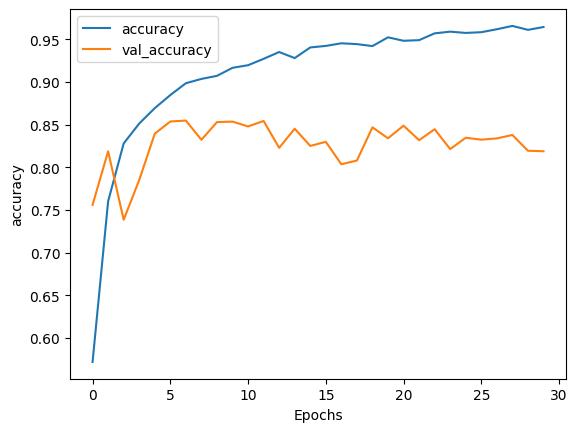

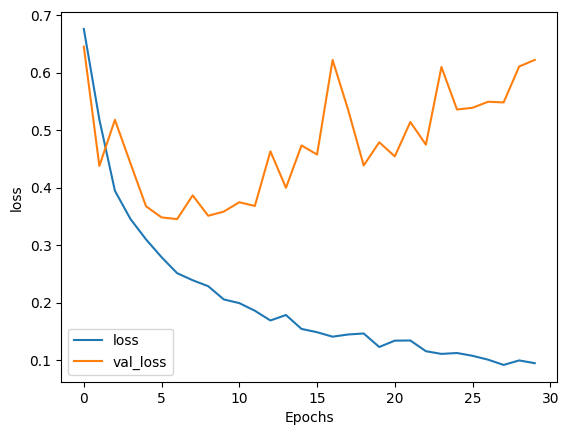

In [31]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 16)          │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (32, 16)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 24)               │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,301 (1.84 MB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,868 (1.22 MB)

Lets clasify our own sentence

In [33]:
sentence = [
    "granny starting to fear spiders in the garden might be real", 
    "game of thrones season finale showing this sunday night"
]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen = 100, 
                       padding = 'post', truncating='post')

print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[0.9692773 ]
 [0.11190511]]


As we can see, the first sentence has much higher chance of being clasufied as sarcastic.

# 4. LSTM

Lets try to improve our model by adding Long Short-Term Memory to it.

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
history = model.fit(training_padded, training_labels, epochs=5, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
625/625 - 62s - 99ms/step - accuracy: 0.8058 - loss: 0.4038 - val_accuracy: 0.8560 - val_loss: 0.3334
Epoch 2/5
625/625 - 55s - 87ms/step - accuracy: 0.9129 - loss: 0.2147 - val_accuracy: 0.8569 - val_loss: 0.3361
Epoch 3/5
625/625 - 81s - 129ms/step - accuracy: 0.9275 - loss: 0.1999 - val_accuracy: 0.8475 - val_loss: 0.4314
Epoch 4/5
625/625 - 54s - 87ms/step - accuracy: 0.9610 - loss: 0.1087 - val_accuracy: 0.8481 - val_loss: 0.4766
Epoch 5/5
625/625 - 57s - 91ms/step - accuracy: 0.9755 - loss: 0.0708 - val_accuracy: 0.8456 - val_loss: 0.5058


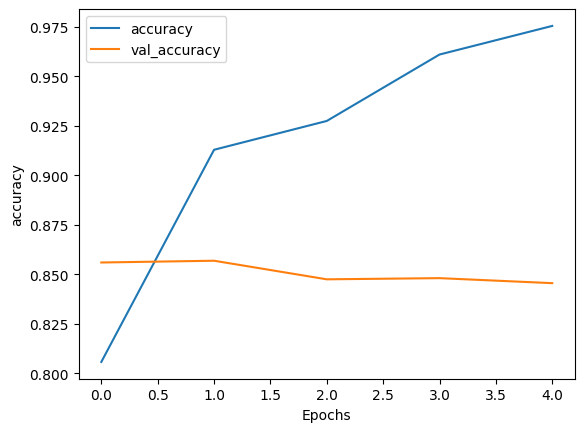

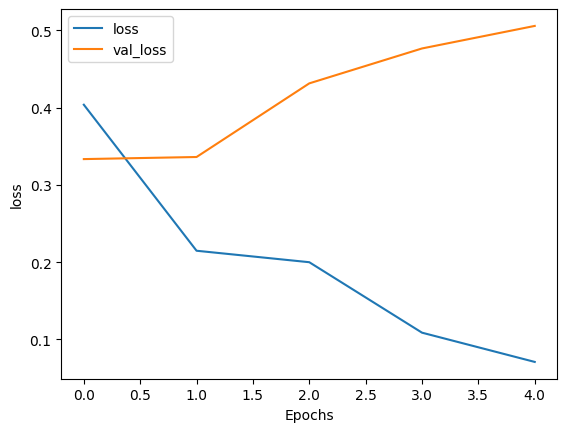

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 100, 16)          │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 100, 128)         │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (32, 64)               │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 24)               │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 1)                │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 732,821 (2.80 MB)

 Trainable params: 244,273 (954.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 488,548 (1.86 MB)

In [38]:
sentence = [
    "granny starting to fear spiders in the garden might be real", 
    "game of thrones season finale showing this sunday night"
]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen = 100, 
                       padding = 'post', truncating='post')

print(model.predict(padded))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
[[0.9429866 ]
 [0.19506088]]


# 5. Generating text

In [39]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2024-10-15 22:34:34--  https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.67.27, 142.250.66.251, 142.250.71.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.67.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: '/tmp/irish-lyrics-eof.txt'

/tmp/irish-lyrics-e 100%[===================>]  67.35K   381KB/s    in 0.2s    

2024-10-15 22:34:34 (381 KB/s) - '/tmp/irish-lyrics-eof.txt' saved [68970/68970]



In [40]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [41]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [42]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [43]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


In [44]:
print(xs[6])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [45]:
print(ys[6])

[0. 0. 0. ... 0. 0. 0.]


In [46]:
print(xs[5])
print(ys[5])

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


In [47]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [48]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.0628 - loss: 6.8140
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.1146 - loss: 5.7743
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.1764 - loss: 4.7798
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.2669 - loss: 3.7619
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.3883 - loss: 2.9038
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4896 - loss: 2.2751
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5858 - loss: 1.8125
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6463 - loss: 1.5111
Epoch 9/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.6926 - loss: 1.2704
Epoch 10/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7307 - loss: 1.1169
Epoch 11/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7465 - loss: 1.0505
Epoch 12/100
377/37

In [49]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

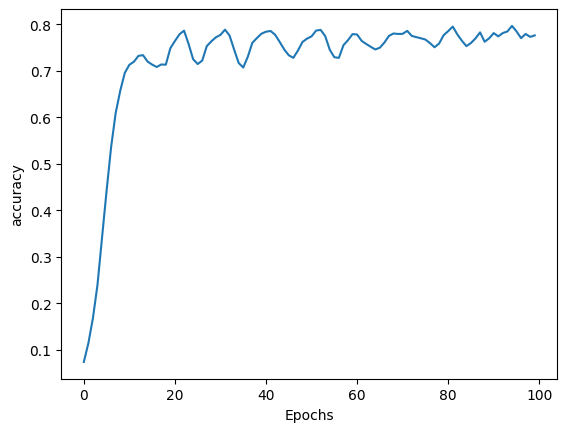

In [50]:
plot_graphs(history, 'accuracy')

In [51]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━